In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator)
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Projections

In Astronomy or in Cartography, one often needs to map a sphere onto a plane. Mapping from a non-Euclidean surface to a Euclidean surface is non-trivial if you want to preserve all the details. Below are some properties based on which you can choose what projection is best for your science purposes. 

1. **Conformal**: These projections preserve angles locally. They are good for representing structures to the eye faithfully - eg. shapes of the continents on Earth. Conformal projections often distort the area to acheive this. Some useful conformal projections are *Sterographic* and the *Mercator* Projection.<br/><br/>

2. **Equal Area**: For statistical purposes, it is more useful to have projections that preserve area- eg. population per sq. mile in a country. Such projections severly suffer from distortions to the shape at wide angles. For example, *Mollweide*, *Hammer-Aitoff* and *Sinusoidal* projections.<br/><br/>

3. **Gnomonic**: Projections in which great circles are straight lines. Only half the sphere can be represented in such a projection. Example- *Gnomonic* projection. <br/><br/>

4. **Equidistant**: Distances from a single point on the map are all on the same scale. For example- *Cylindrical equidistant* and *Azimuthal equidistant* projection.<br/><br/>

5. **Perspective**: The view you would get by placing your eye at one position. For example- if your eye was at infinity you would see the globe. This particular projection is called an *Orthographic* projection.

See https://www.youtube.com/watch?v=eLqC3FNNOaI for fun.

# Using Cartopy to Create a Projection

The job of a projection is to create a mapping between image/array coordinates (pixels) and some other coordinate system--in this case, the latitude/longitude of your sphere.  This can be done manually.  For example, you could make a cylindrical projection by making two 2D arrays: one containing the longitudes of each image/array pixel and another containing the latitudes.

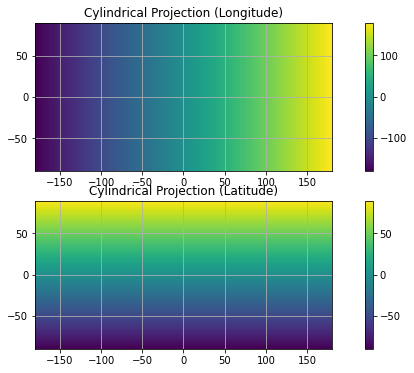

In [2]:
NLON,NLAT = 1000, 500 # the number of pixels in longitude and latitude
xs,ys = np.indices((NLAT,NLON)) # get the array indices for each pixel
lats = (xs - NLAT/2) * 180 / NLAT # scale [0:NLAT) to [-90:90)
lons = (ys - NLON/2) * 360 / NLON # scale [0:NLON) to [-180:180)

plt.figure(figsize=(12,6))
plt.subplot(211)

plt.title('Cylindrical Projection (Longitude)')
plt.imshow(lons, origin='lower', extent=(-180,180,-90,90))
plt.grid()
plt.colorbar()

plt.subplot(212)
plt.title('Cylindrical Projection (Latitude)')
plt.imshow(lats, origin='lower', extent=(-180,180,-90,90))
plt.grid()
plt.colorbar()
plt.show()

Alternately, you can use cartopy
for this functionality.  You can explicitly ask for an image grid, and
it will tell you the longitude and latitude of each pixel coordinate, as shown below.

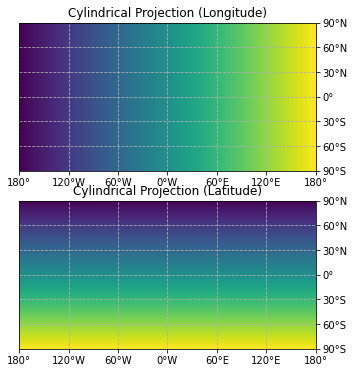

In [3]:
proj = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig, axes = plt.subplots(nrows=2, figsize=(12,6), subplot_kw={'projection': proj})

axes[0].set_title('Cylindrical Projection (Longitude)')
axes[0].imshow(lons, extent=(-180, 180, -90, 90), transform=data_crs)

axes[1].set_title('Cylindrical Projection (Latitude)')
axes[1].imshow(lats, extent=(-180, 180, -90, 90), transform=data_crs)

for ax in axes:
    ax.yaxis.tick_right()
    ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=data_crs)
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=data_crs)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.gridlines(crs=data_crs, draw_labels=False, linestyle='--')

You can try other projections (e.g. Mollweide, below).  Some projections have image pixels that
do not map to the sphere at all.  These may need to be manually masked to avoid distracting features.
One thing in particular to be aware of is that the values in these blank pixels can mess up the
automatic scaling that imshow does.  If you find that you image looks uniformly dark, try manually
setting vmax and vmin.

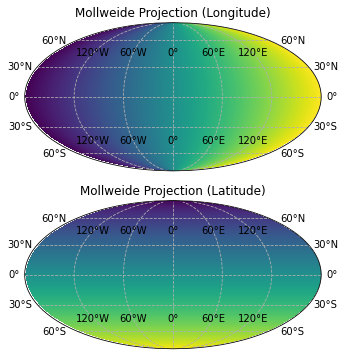

In [4]:
proj = ccrs.Mollweide()
data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, figsize=(12,6), subplot_kw={'projection': proj})

axes[0].set_title('Mollweide Projection (Longitude)')
axes[0].imshow(lons, extent=(-180, 180, -90, 90), transform=data_crs)

axes[1].set_title('Mollweide Projection (Latitude)')
axes[1].imshow(lats, extent=(-180, 180, -90, 90), transform=data_crs)

for ax in axes:
    ax.gridlines(crs=data_crs, draw_labels=True, linestyle='--')

Some projections require you to provide the center point of the projection.  For example, orthographic projections
need both a lat_0 and a lon_0 to center at.  

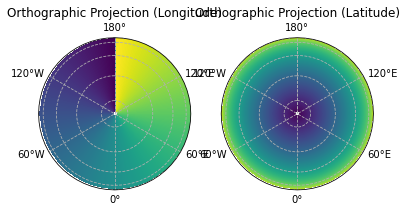

In [5]:
proj = ccrs.Orthographic(central_latitude=90)
data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(ncols=2, figsize=(6,14), subplot_kw={'projection': proj})

axes[0].set_title('Orthographic Projection (Longitude)')
axes[0].imshow(lons, extent=(-180, 180, -90, 90), transform=data_crs)

axes[1].set_title('Orthographic Projection (Latitude)')
axes[1].imshow(lats, extent=(-180, 180, -90, 90), transform=data_crs)

for ax in axes:
    ax.gridlines(crs=data_crs, draw_labels=True, linestyle='--')

Cartopy has a lot of other things it can do.  Some is very useful.  Some is irrelevant for astronomy.

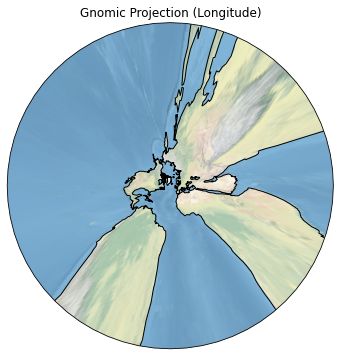

In [6]:
proj = ccrs.Gnomonic(central_latitude=60, central_longitude=-30)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=proj)

ax.set_title('Gnomic Projection (Longitude)')
ax.coastlines()
ax.stock_img()

# Working with a Spherical Data Set

In this section, we will work with a spherical dataset, the Haslam 408 MHz survey.  Healpix is a method for representing spherical datasets with a series of $12N^2$ pixels.  Each pixel contains equal area, but not all pixels have the same shape.  One of the most powerful aspects of Healpix is its support for looking up the pixels nearest a requested coordinate and interpolating the nearest pixels to estimate a value at that coordinate.

Using this functionality (which is wrapped into Python in the AIPY package), we can request the map value at each $(\theta,\phi)$ given the lat/lon in each pixel coordinate, thereby creating a projection of the spherical data set onto a 2D array.  The only trick is recognizing the difference between $\theta$ (measured from the pole) and latitude (measured from the equator).

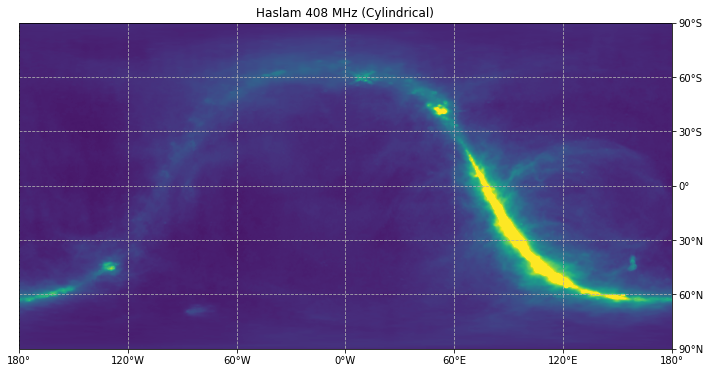

In [7]:
from aipy.healpix import HealpixMap
h = HealpixMap(fromfits='lambda_haslam408_dsds_eq.fits')

NLON,NLAT = 1000, 500 # the number of pixels in longitude and latitude
xs,ys = np.indices((NLAT,NLON)) # get the array indices for each pixel
lats = (xs - NLAT/2) * 180 / NLAT # scale [0:NLAT) to [-90:90)
lons = (ys - NLON/2) * 360 / NLON # scale [0:NLON) to [-180:180)
phi, theta = lons*np.pi/180, np.pi/2 - lats*np.pi/180
data = h[theta.flatten(),phi.flatten()]
data.shape = lons.shape

proj = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

plt.figure(figsize=(12,6))
ax = plt.axes(projection=proj)
ax.set_title('Haslam 408 MHz (Cylindrical)')
ax.imshow(data[:,::-1], vmax=200, vmin=0, extent=(-180,180,90,-90), origin='lower', transform=data_crs)

ax.yaxis.tick_right()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=data_crs)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=data_crs)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
_ = ax.gridlines(crs=data_crs, draw_labels=False, linestyle='--')

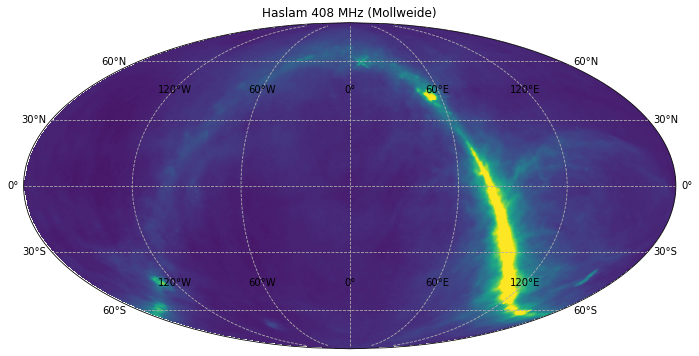

In [8]:
proj = ccrs.Mollweide()
data_crs = ccrs.PlateCarree()

plt.figure(figsize=(12,6))
ax = plt.axes(projection=proj)
ax.set_title('Haslam 408 MHz (Mollweide)')
ax.imshow(data, vmax=200, vmin=0, extent=(180,-180,90,-90), transform=data_crs)

_ = ax.gridlines(crs=data_crs, draw_labels=True, linestyle='--')

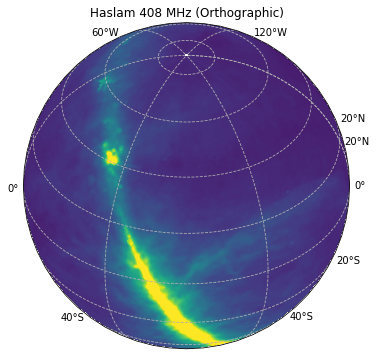

In [10]:
proj = ccrs.Orthographic(central_latitude=37, central_longitude=90)
data_crs = ccrs.PlateCarree()


plt.figure(figsize=(12,6))
ax = plt.axes(projection=proj)
ax.set_title('Haslam 408 MHz (Orthographic)')
ax.imshow(data, vmax=200, vmin=0, extent=(180,-180,90,-90), transform=data_crs)

_ = ax.gridlines(crs=data_crs, draw_labels=True, linestyle='--')